<a href="https://colab.research.google.com/github/yuminliu/KaggleHousePrices/blob/master/HousePrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
import copy
%matplotlib inline

read in data

In [0]:
#%% read in data
#filepath = '../data/train.csv'
#train = pd.read_csv(filepath)
#test = pd.read_csv('../data/test.csv')
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

separate id

In [0]:
train_id = train['Id']
train = train.drop(['Id'],axis=1)
test_id = test['Id']
test = test.drop(['Id'],axis=1)
test['SalePrice'] = 0

remove outliers of continuous features in training data, first get the continuous features

In [0]:
continuous = list(['LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',\
                   'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',\
                   'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch',\
                   'ScreenPorch','MiscVal','SalePrice'])

plot the continuous features and fit a regression the them, and then visually find out the outliers

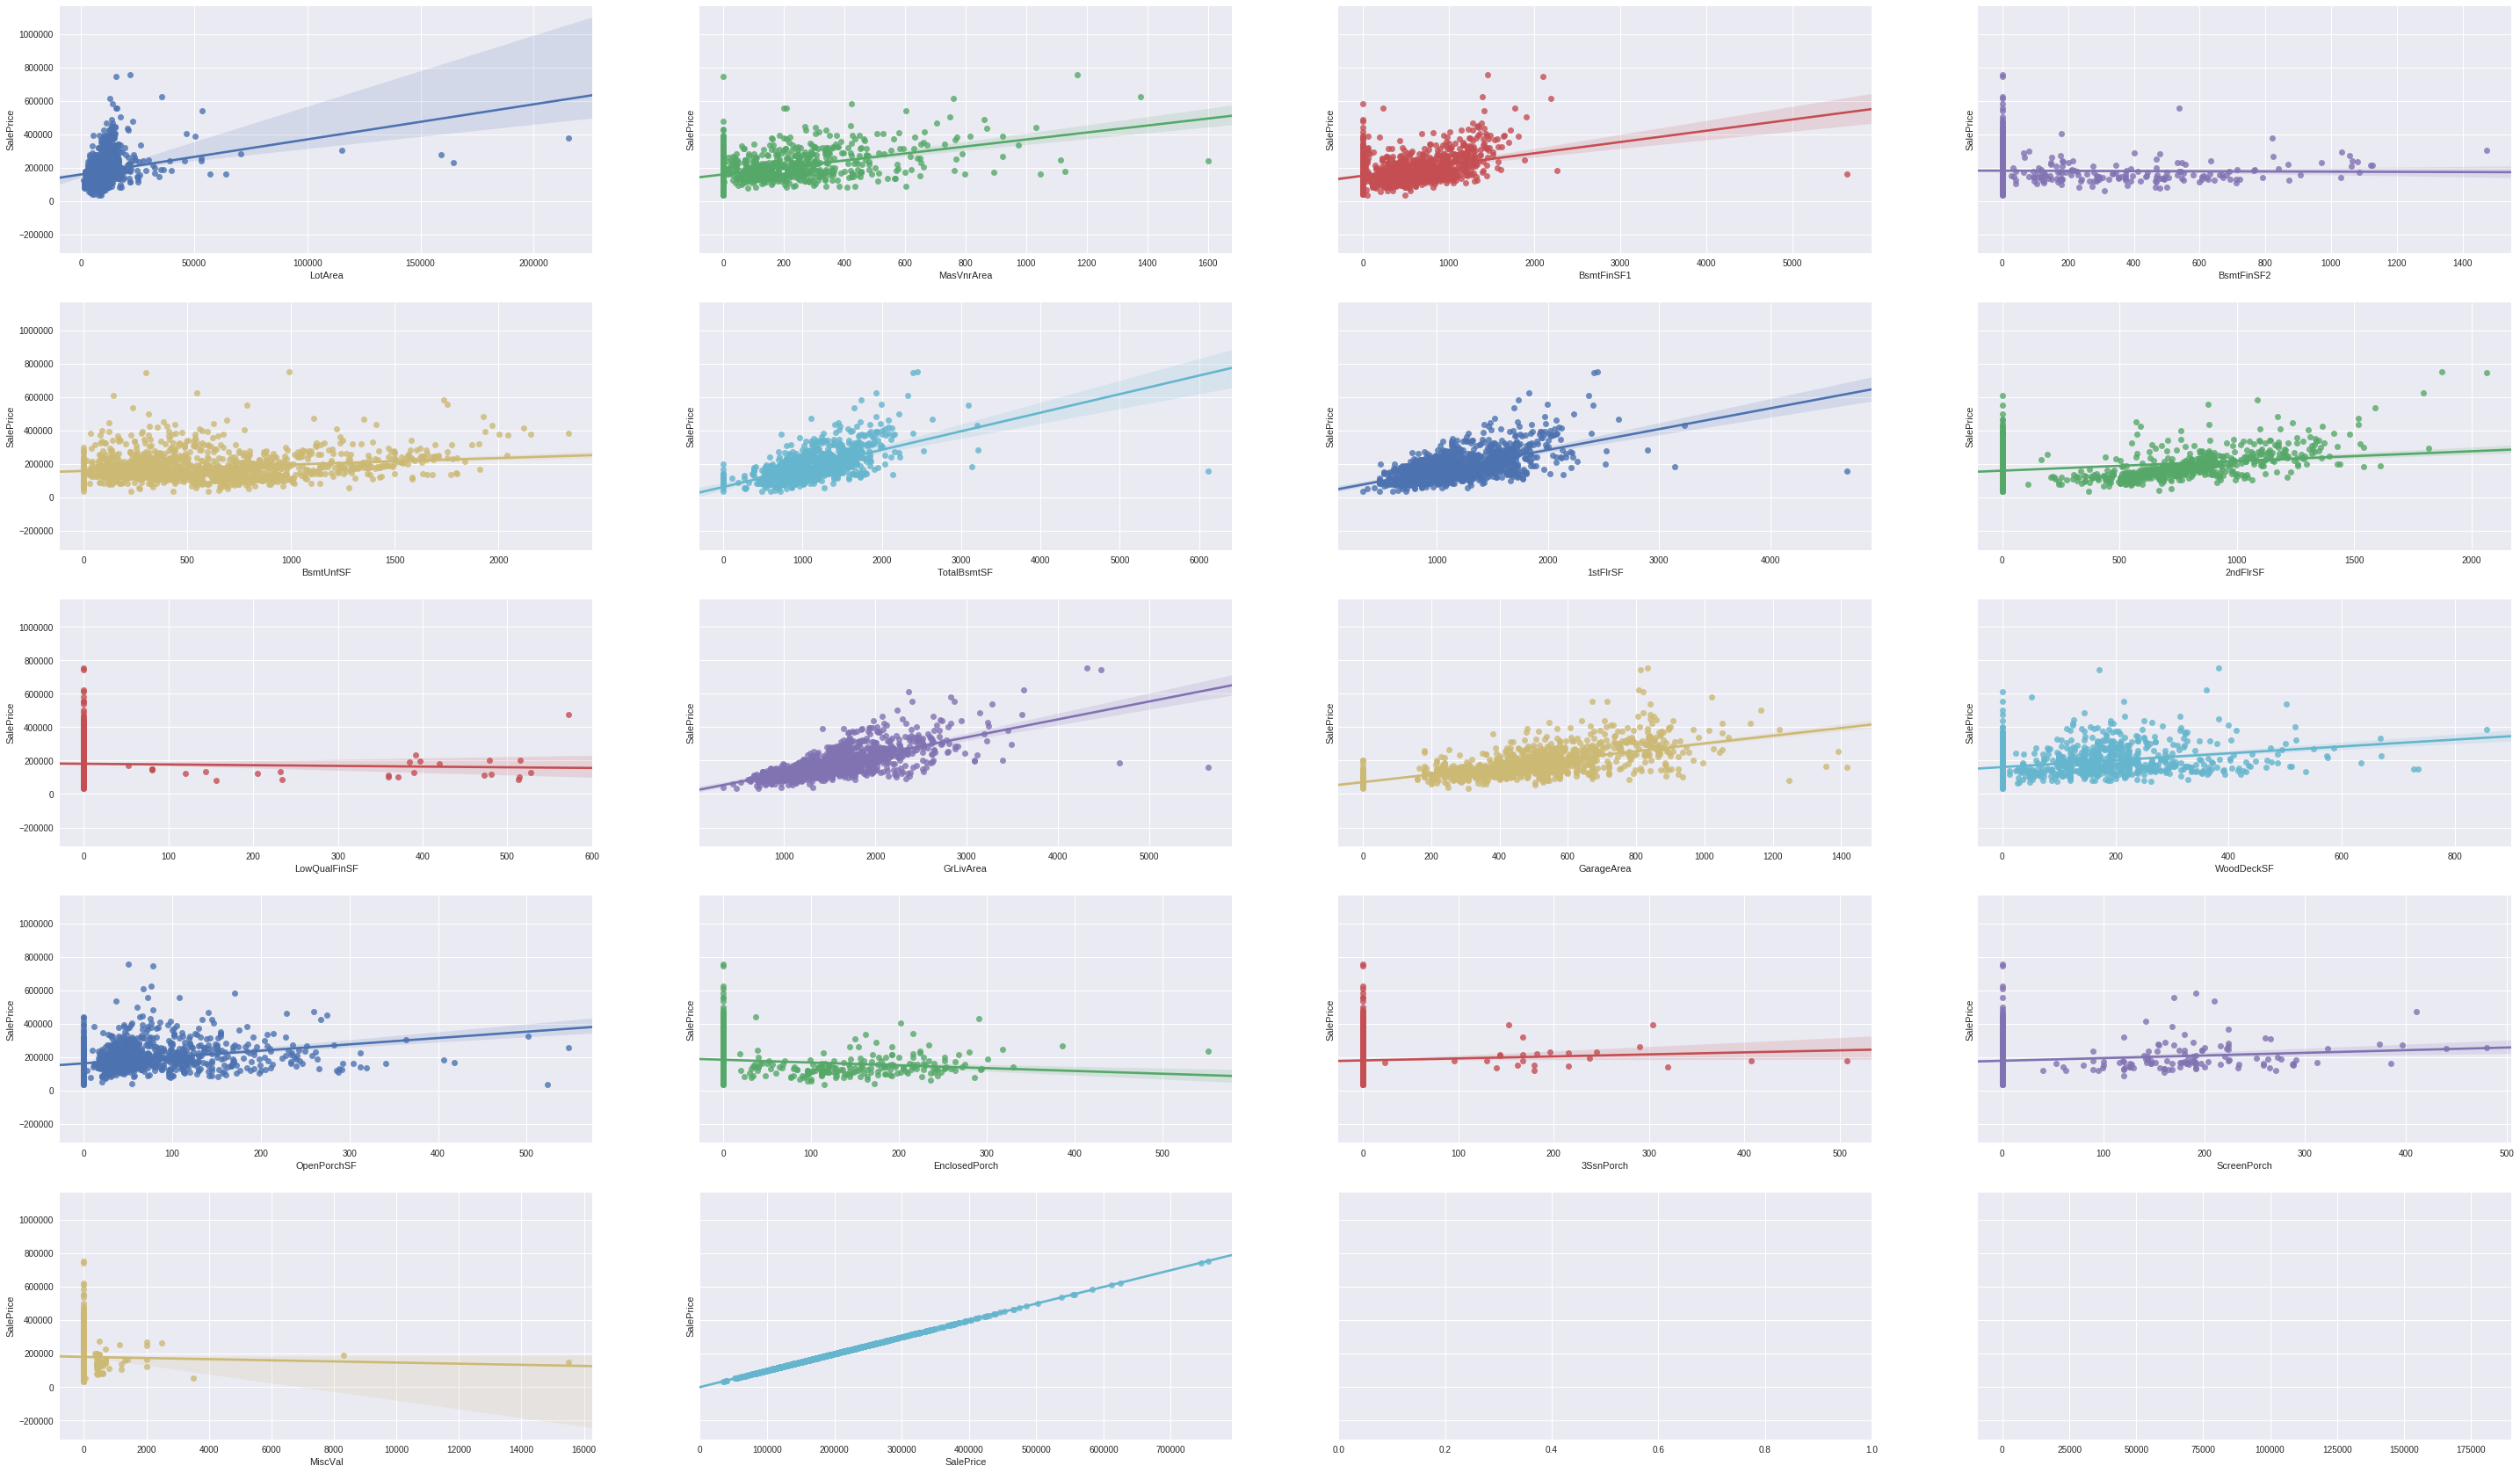

In [25]:
ncols = 4
nrows = int(np.ceil(len(continuous)/ncols))
fig, axs = plt.subplots(ncols=ncols,nrows=nrows,figsize=(50,30),sharey=True)
for i in range(nrows):
   for j in range(ncols):
       ind = i*ncols+j
       if(ind>=len(continuous)):
           break
       var = continuous[i*ncols+j]
       sns.regplot(x=var, y='SalePrice', data=train, ax=axs[i][j])

now remove the outliers in the training data

In [0]:
#train = train.drop(train[(train['GrLivArea']>4000)].index)
train = train.drop(train.loc[train['LotArea']>100000].index,axis=0)
train = train.drop(train.loc[train['BsmtFinSF1']>2000].index,axis=0)
train = train.drop(train.loc[train['TotalBsmtSF']>4000].index,axis=0)
train = train.drop(train.loc[train['1stFlrSF']>3000].index,axis=0)
train = train.drop(train.loc[train['GrLivArea']>4500].index,axis=0)
train = train.drop(train.loc[train['MiscVal']>3000].index,axis=0)
train = train.drop(train.loc[train['EnclosedPorch']>400].index,axis=0)
train = train.drop(train.loc[train['GarageArea']>1200].index,axis=0)
#train = train.drop(train.loc[train['MasVnrArea']>1400].index,axis=0)
#train = train.drop(train.loc[train['WoodDeckSF']>700].index,axis=0)

we may want to delete missing data in training data. This will have pros and cons. In one hand, removing them will give more "clean" data for training thus maybe benificial; in the other hand, removing them will resulting less data for training thus maybe harmful

In [0]:
#for var in list(train.columns.values):
#   train = train.drop(train.loc[train[var].isnull()].index,axis=0)
#absnum_train = train.isnull().sum().sort_values(ascending=False)
#percent_train = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
#missing_train = pd.concat([absnum_train,percent_train],axis=1,keys=['AbsNum_train','Percent_train'])
#missing_train.head(20)   
#absnum_test = test.isnull().sum().sort_values(ascending=False)
#percent_test = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
#missing_test = pd.concat([absnum_test,percent_test],axis=1,keys=['AbsNum_test','Percent_test'])
#missing_test.head(20) 

In [28]:
pd.__version__

'0.22.0'

concatenate training and testing data to do further preprocessing

In [0]:
# data_all = data_all = pd.concat([train,test],axis=0,sort=False).reset_index(drop=True)
data_all = data_all = pd.concat([train,test],axis=0).reset_index(drop=True)

fill in missing data according to different type

in all the cases the values in 'Utilities' are 'AllPub' except for 3 cases, thus it will not be helpful for prediction and it's safe to remove.

In [0]:
vartodelete = list(['Utilities'])
for var in vartodelete:
    data_all = data_all.drop(var,axis=1)

NA in those below categorical values means absence of the features, thus they are filled with 'None'

In [0]:
nanisnone = list(['GarageCond','GarageFinish','GarageQual','GarageType','BsmtCond',\
                'BsmtExposure','BsmtQual','BsmtFinType2','BsmtFinType1',\
                'MasVnrType','PoolQC','MiscFeature','Alley',\
                'Fence','FireplaceQu'])
for var in nanisnone: 
    data_all[var] = data_all[var].fillna('None')

NA in those below numerical values means absence of the features, thus they are filled with 0

In [0]:
naniszero = list(['MasVnrArea','GarageCars','GarageArea','BsmtFinSF1',\
                  'BsmtFullBath','BsmtHalfBath','TotalBsmtSF','BsmtUnfSF',\
                  'BsmtFinSF2'])
for var in naniszero:
    data_all[var] = data_all[var].fillna(0)

NA in those categorical values means really no data, thus filled with most common values seem all over the same column

In [0]:
nanismode = list(['MSZoning','Functional','Exterior1st','Exterior2nd',\
                  'KitchenQual','SaleType','Electrical'])
for var in nanismode:
    data_all[var] = data_all[var].fillna(data_all[var].mode()[0])

NA in those categorical values means really no data, thus filled with most common values seem all over the same column and maybe more accurate by filling with most common values in the same Neighbour

In [0]:
nanisothers = list(['LotFrontage','GarageYrBlt']) 
for var in nanisothers:
    data_all[var] = data_all.groupby("Neighborhood")[var].transform(lambda x: x.fillna(x.median()))


tranform acutal categorical data or numerical data

In [0]:
#num2cat_var = list(['MSSubClass'])
#cat2num_var = list(['GarageYrBlt'])
num2cat_var = list(['MSSubClass','YrSold','MoSold'])
cat2num_var = list([])
for var in num2cat_var:
    data_all[var] = data_all[var].astype(str)
for var in cat2num_var:
    data_all[var] = data_all[var].astype(float)

encode categorical data whose order may contain information

In [0]:
from sklearn.preprocessing import LabelEncoder
vartoencode = list(['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold'])
#vartoencode = list(['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
#        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
#        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
#        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir'])
lbe = LabelEncoder() 
for var in vartoencode:
    lbe.fit(list(data_all[var].values)) 
    data_all[var] = lbe.transform(list(data_all[var].values))
#    lbe.fit(list(train[var].values)) 
#    train[var] = lbe.transform(list(train[var].values))
#    lbe.fit(list(test[var].values)) 
#    test[var] = lbe.transform(list(test[var].values))

transform target y to log to accelerate training 

In [0]:
data_all['SalePrice'] = np.log1p(data_all['SalePrice'])

get dummy variables for the categorical data

In [0]:
data_all = pd.get_dummies(data_all)

split training and testing data

In [0]:
train_num = len(train)
test_num = len(test)

train = data_all[:train_num]
test = data_all[train_num:]

train_y = train['SalePrice']
train_x = train.drop('SalePrice',axis=1)
test_y = test['SalePrice']
test_x = test.drop('SalePrice',axis=1)

transform dataframe into numpy arrays, this is for xgb

In [0]:
train_y = train_y.values
train_x = train_x.values
test_y = test_y.values
test_x = test_x.values

use PCA to reduce dimensions

In [41]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
pca.fit_transform(train_x)
pca.transform(test_x)

array([[ 1.59988307e+03, -8.14566152e+02,  2.00563317e+02, ...,
        -4.25868863e-02,  4.21790619e-03, -3.58129318e-02],
       [ 4.28654256e+03, -3.96389460e+02,  5.35336563e+02, ...,
        -2.33945976e-01,  8.75324894e+00, -5.55768692e+00],
       [ 3.83838463e+03, -2.86067628e+02, -2.44833245e+02, ...,
        -3.43307748e-02,  6.55134137e-02,  2.75763161e-03],
       ...,
       [ 1.00036107e+04, -8.31934764e+02,  6.45665483e+02, ...,
         1.43776687e-01,  4.34370271e-02,  1.32861489e-01],
       [ 4.16577282e+02, -6.78127426e+02,  1.06061863e+02, ...,
        -3.54659681e-01, -4.66008096e-01,  2.01750516e-01],
       [-3.39309731e+02,  3.63097026e+02, -3.98182439e+02, ...,
         3.66477362e-02, -1.04314059e-01, -5.17645655e-02]])

split training data into new training data and validation data

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.25, random_state=42)

fit to models

In [0]:
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor

def write_submission(y_test_pred,test_id=test_id,filename='submission.csv'):
    submission = pd.DataFrame()
    submission['Id'] = test_id
    submission['SalePrice'] = y_test_pred
    #submission.to_csv('../results/'+filename,index=False)
    submission.to_csv('./'+filename,index=False)

lasso regression

In [46]:
alphas = [1e-5,5e-5,1e-4,5e-4,1e-3,5e-3,1e-2,1e-1,1.0,10.0]    
lasso = LassoCV(alphas=alphas)
lasso.fit(X_train, y_train)
print(lasso.alpha_)
y_train_pred_lasso = lasso.predict(X_train)
y_valid_pred_lasso = lasso.predict(X_valid)
y_test_pred_lasso = lasso.predict(test_x)
y_test_pred_lasso = np.exp(y_test_pred_lasso) - 1
train_rmse_lasso = np.sqrt(np.mean((y_train-y_train_pred_lasso)**2))
valid_rmse_lasso = np.sqrt(np.mean((y_valid-y_valid_pred_lasso)**2))
print("lasso train rmse is: {};\nvalidate rmse is: {}".format(train_rmse_lasso,valid_rmse_lasso))
write_submission(y_test_pred=y_test_pred_lasso,filename='lasso_submission.csv')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.001
lasso train rmse is: 0.10313618867895027;
validate rmse is: 0.12344198521055018


ridge regression

In [47]:
alphas = [1e-5,5e-5,1e-4,5e-4,1e-3,5e-3,1e-2,1e-1,1.0,10.0]    
ridge = RidgeCV(alphas=alphas)
ridge.fit(X_train, y_train)
print(ridge.alpha_)
y_train_pred_ridge = ridge.predict(X_train)
y_valid_pred_ridge = ridge.predict(X_valid)
y_test_pred_ridge = ridge.predict(test_x)
y_test_pred_ridge = np.exp(y_test_pred_ridge) - 1
train_rmse_ridge = np.sqrt(np.mean((y_train-y_train_pred_ridge)**2))
valid_rmse_ridge = np.sqrt(np.mean((y_valid-y_valid_pred_ridge)**2))
print("ridge train rmse is: {};\nvalidate rmse is: {}".format(train_rmse_ridge,valid_rmse_ridge))
write_submission(y_test_pred=y_test_pred_ridge,filename='ridge_submission.csv')

10.0
ridge train rmse is: 0.09622882117586912;
validate rmse is: 0.1194622321539107


random forest regression

In [48]:
n_estimators = 100
randomforest = RandomForestRegressor(n_estimators=n_estimators,\
                                     max_features='sqrt')
randomforest.fit(X_train, y_train)
#print(-np.sort(-randomforest.feature_importances_)[:30])
#a = -np.sort(-randomforest.feature_importances_)
y_train_pred_randomforest = randomforest.predict(X_train)
y_valid_pred_randomforest = randomforest.predict(X_valid)
y_test_pred_randomforest = randomforest.predict(test_x)
y_test_pred_randomforest = np.exp(y_test_pred_randomforest) - 1
train_rmse_randomforest = np.sqrt(np.mean((y_train-y_train_pred_randomforest)**2))
valid_rmse_randomforest = np.sqrt(np.mean((y_valid-y_valid_pred_randomforest)**2))
print("randomforest train rmse is: {};\nvalidate rmse is: {}".format(train_rmse_randomforest,valid_rmse_randomforest))
write_submission(y_test_pred=y_test_pred_randomforest,filename='randomforest_submission.csv')

[0.08776987 0.0684522  0.05268901 0.04685729 0.04612667 0.04545931
 0.04330226 0.04076136 0.03792507 0.02786551 0.02734105 0.02502086
 0.02374382 0.02100096 0.02066697 0.0205811  0.02015816 0.01899895
 0.01841463 0.01662046 0.01621728 0.01613607 0.01142461 0.0103087
 0.00973315 0.0096811  0.00895265 0.00786549 0.00744458 0.00671554]
randomforest train rmse is: 0.05538184860481573;
validate rmse is: 0.14207668188786743


XGBoost regression

In [49]:
import xgboost# as xgb
xgb = xgboost.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
xgb.fit(X_train,y_train)
y_train_pred_xgb = xgb.predict(X_train)
y_valid_pred_xgb = xgb.predict(X_valid)
y_test_pred_xgb = xgb.predict(test_x)
y_test_pred_xgb = np.exp(y_test_pred_xgb) - 1
train_rmse_xgb = np.sqrt(np.mean((y_train-y_train_pred_xgb)**2))
valid_rmse_xgb = np.sqrt(np.mean((y_valid-y_valid_pred_xgb)**2))
print("xgb train rmse is: {};\nvalidate rmse is: {}".format(train_rmse_xgb,valid_rmse_xgb))
write_submission(y_test_pred=y_test_pred_xgb,filename='xgb_submission.csv')

xgb train rmse is: 0.07949171249250075;
validate rmse is: 0.1251421756705282


stacking regression

In [51]:
!pip install mlxtend

    100% |████████████████████████████████| 1.3MB 14.4MB/s 


In [52]:
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
lr = LinearRegression()
lasso = LassoCV(alphas=alphas)
#ridge = Ridge(random_state=1)
ridge = RidgeCV(alphas=alphas)
rf = RandomForestRegressor(n_estimators=n_estimators)
svr_lin = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')
regressors = [svr_lin, lr, ridge]
regressors = [lr,lasso,ridge,rf,svr_lin]
sr = StackingRegressor(regressors=regressors, 
                           meta_regressor=svr_rbf)
sr.fit(X_train, y_train)
y_train_pred_sr = sr.predict(X_train)
y_valid_pred_sr = sr.predict(X_valid)
y_test_pred_sr = sr.predict(test_x)
y_test_pred_sr = np.exp(y_test_pred_sr) - 1
train_rmse_sr = np.sqrt(np.mean((y_train-y_train_pred_sr)**2))
valid_rmse_sr = np.sqrt(np.mean((y_valid-y_valid_pred_sr)**2))
print("sr train rmse is: {};\nvalidate rmse is: {}".format(train_rmse_sr,valid_rmse_sr))
write_submission(y_test_pred=y_test_pred_sr,filename='sr_submission.csv')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


sr train rmse is: 0.08487013377660504;
validate rmse is: 0.17591136939778573
